# The Task

A chain of three grocery stores wants to forecast the chain's total revenue in January 2021. As data for building models, the company provides revenue data for the period `2020.05.01 - 2020.12.31`. The forecast should be by days.

### Plan:

1. Research the data provided
2. Build a strategy for calculating the forecast model
3. Develop machine learning

In [1]:
import datetime as datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # это библиотека для управления warning'ами — то есть различными предупреждениями
                # ниже мы с помощью нее игнорим лишние предупреждения
                # мы можем это убрать, но где-то всплывали ворнинги, и чтобы они не раздражали и не вызывали вопросов, мы их отключим

warnings.filterwarnings('ignore')

In [2]:
revenue_data = pd.read_csv('revenue_01.05.2020-31.12.2020.csv')

In [3]:
revenue_data.dtypes

date             object
revenue         float64
store_branch      int64
dtype: object

In [4]:
revenue_data['date'] = pd.to_datetime(revenue_data['date'])

In [5]:
revenue_data.head()

,date,revenue,store_branch
0,2020-05-01,27913.47220,1
1,2020-05-01,79628.53301,2
2,2020-05-01,106898.12180,3
3,2020-05-02,37477.72056,1
4,2020-05-02,129503.46070,2


In [6]:
revenue_data.shape

(735, 3)

Our data contains general information about revenue in each of the three branch stores for each day from 01.05.2020 till 31.12.2020.

Our task is to make a forecast for total revenue for all three branch stores, so let's check the data in general.

### Graphical data analysis

Building a histogram that will give us frequency of revenue indicators. 

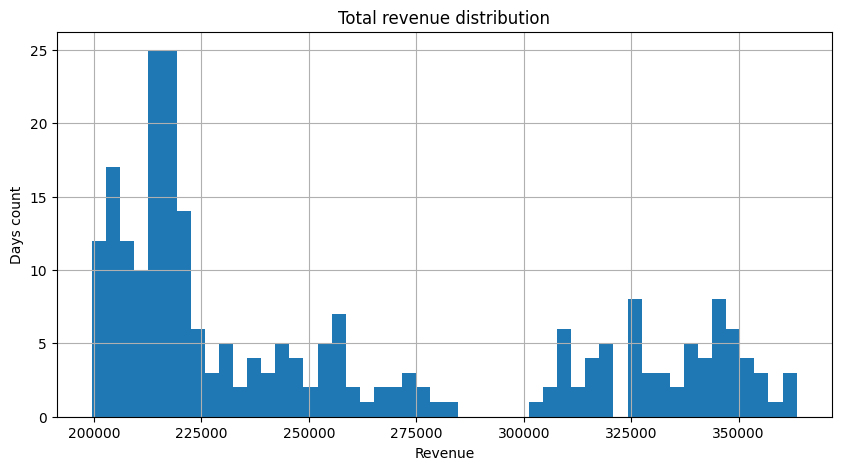

In [7]:
# revenue sum frequency for all three branch stores by days

plt.figure(figsize=(10,5))
plt.title('Total revenue distribution')
plt.xlabel('Revenue')
plt.ylabel('Days count')
plt.grid()

plt.hist(revenue_data.groupby('date')['revenue'].sum(), bins=50)

plt.show()

We see that in the total revenue, there is a mixture. Let's try to build a more detailed histogram of revenue without grouping by days.

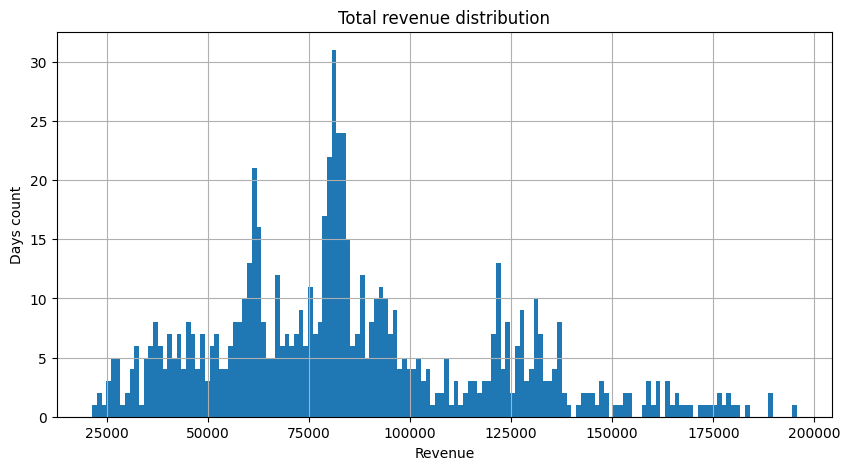

In [8]:
plt.figure(figsize=(10,5))
plt.title('Total revenue distribution')
plt.xlabel('Revenue')
plt.ylabel('Days count')
plt.grid()

plt.hist(revenue_data['revenue'], bins=150)

plt.show()

The obvious mixture in the data. Let's see if division by store branches solves it.

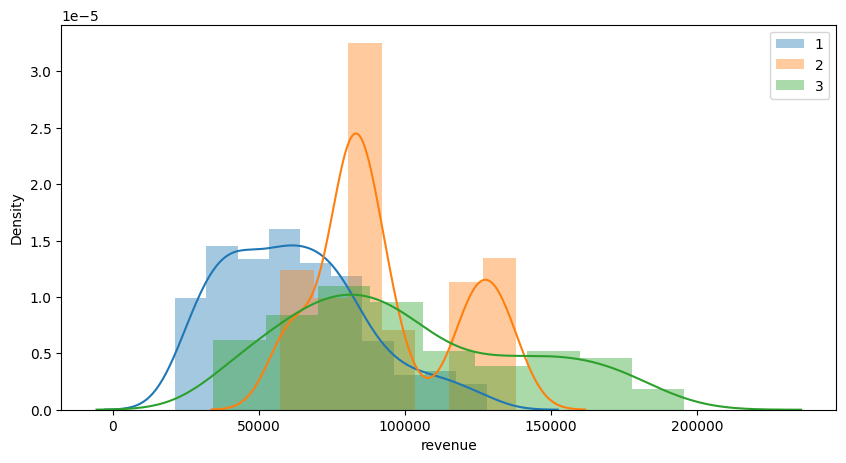

In [9]:
plt.figure(figsize=(10, 5)) 

branch = pd.unique(revenue_data['store_branch'])

for i in branch: 
    sns.distplot(revenue_data.loc[revenue_data['store_branch'] == i]['revenue'], label = i);
    
plt.legend();

As we see, the data mixture is explained by stores branch distribution, but not fully.

Let's see how the data looks like in the form of time series (in total and divided by branches)

### Time series visualization

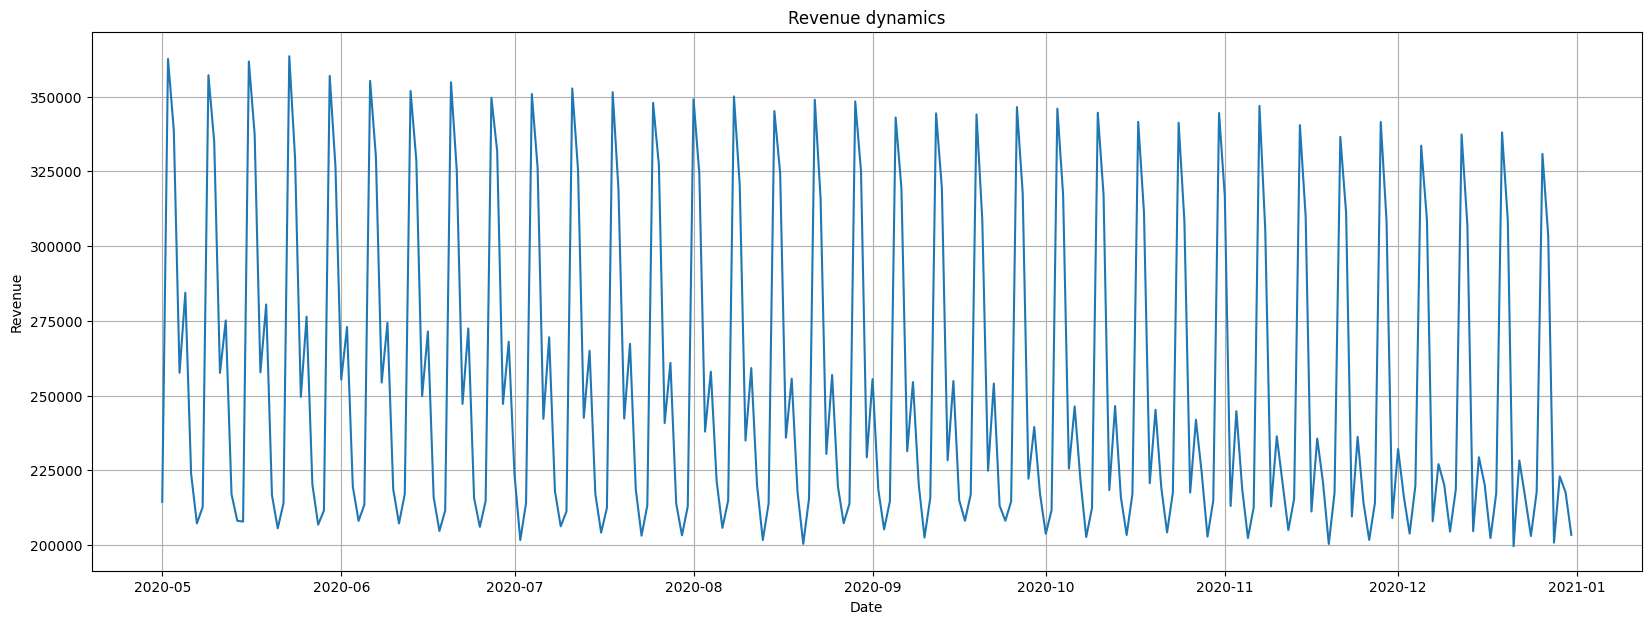

In [10]:
import matplotlib.dates as mdates

# total revenue
plt.figure(figsize=(20,7))
plt.title('Revenue dynamics')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid()

#locator = mdates.MonthLocator() # get month signatures
#X = plt.gca().xaxis # apply to the X axis
#X.set_major_locator(locator) # locator parameters to the axis

sns.lineplot(
        x = revenue_data.groupby('date')['revenue'].sum().index, 
        y = revenue_data.groupby('date')['revenue'].sum()
        )

plt.show()

Do the same for each store branch.

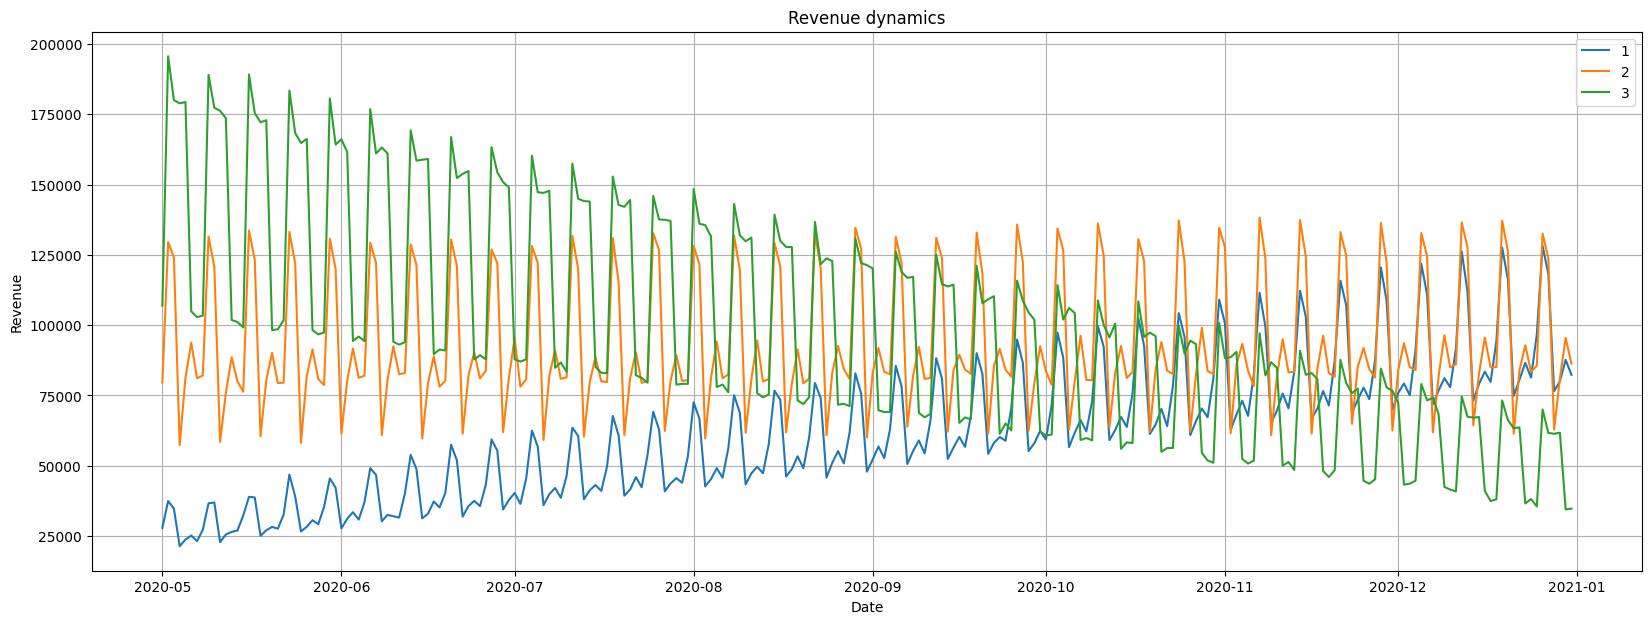

In [11]:
# revenue by store branch
plt.figure(figsize=(20,7))
plt.title('Revenue dynamics')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid()

for i in pd.unique(revenue_data['store_branch']):
    sns.lineplot(
        x = revenue_data.loc[revenue_data['store_branch'] == i]['date'], 
        y = revenue_data.loc[revenue_data['store_branch'] == i]['revenue'],
        label = i);

locator = mdates.MonthLocator()
X = plt.gca().xaxis
X.set_major_locator(locator)

Based on the graphical data analysis, the following conclusions and assumptions can be drawn:
- there is a mixture in the data caused by different branches having different revenues on average
- you can see trends in the data (uptrend for branches 1 and 2 and downtrend for branch 3)
- there is a mixture in the data, caused more by seasonality (this is indicated by the cycliсity of the time series)

Thus, as potential hypotheses that will help improve the quality of the predictive model, worth to consider:
- branch division
- highlight a linear trend
- to take seasonality into account

Let's split our data on train and test sets. 
- 2020.05.01 - 2020.11.30 — train
- 2020.12.01 - 2020.12.31 — test

In [12]:
revenue_data.head()

,date,revenue,store_branch
0,2020-05-01,27913.47220,1
1,2020-05-01,79628.53301,2
2,2020-05-01,106898.12180,3
3,2020-05-02,37477.72056,1
4,2020-05-02,129503.46070,2


In [13]:
train = revenue_data.loc[revenue_data['date'] < '2020.12.01']
test = revenue_data.loc[revenue_data['date'] >= '2020.12.01']
train.shape, test.shape

((642, 3), (93, 3))

### Building first model for general revenue

Group revenue from each store branch by day to create datasets for first model learning.

In [14]:
train_0 = train.groupby(['date'])['revenue'].sum().reset_index()
test_0 = test.groupby(['date'])['revenue'].sum().reset_index()

In [15]:
train_0.head()

,date,revenue
0,2020-05-01,214440.12701
1,2020-05-02,362596.05186
2,2020-05-03,338862.71773
3,2020-05-04,257627.77520
4,2020-05-05,284399.01032


In [16]:
from prophet import Prophet

model = Prophet()
model

In [17]:
# Renaming datasets columns in accordance with "Prophet" documentation

train_0 = train_0.rename(columns = {'date':'ds', 'revenue':'y'})
test_0 = test_0.rename(columns = {'date':'ds', 'revenue':'y'})

In [18]:
train_0.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [19]:
# Training first model without parameters

model.fit(train_0)

10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing


**Model quality**

Checking the model quality we need to define the forecast horizon (in this case it's a month) and create a data frame with future dates for the model to build the forecast.

The forecast will be made for a given number of days from the training model's last day, as our data has the day granularity.

In [20]:
future = model.make_future_dataframe(periods = 31)
future.tail(31)

,ds
214,2020-12-01
215,2020-12-02
216,2020-12-03
217,2020-12-04
218,2020-12-05
219,2020-12-06
220,2020-12-07
221,2020-12-08
222,2020-12-09
223,2020-12-10


Now we can make a prediction. Confidence interval - 95%.

In [21]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-05-01,267898.910046,215964.151849,232806.326555,267898.910046,267898.910046,-43326.812785,-43326.812785,-43326.812785,-43326.812785,-43326.812785,-43326.812785,0.0,0.0,0.0,224572.097261
1,2020-05-02,267797.775290,351415.718548,368109.189167,267797.775290,267797.775290,91775.111839,91775.111839,91775.111839,91775.111839,91775.111839,91775.111839,0.0,0.0,0.0,359572.887129
2,2020-05-03,267696.640534,323850.173581,341023.509615,267696.640534,267696.640534,64220.801720,64220.801720,64220.801720,64220.801720,64220.801720,64220.801720,0.0,0.0,0.0,331917.442254
3,2020-05-04,267595.505778,235868.409555,252945.934394,267595.505778,267595.505778,-22921.669240,-22921.669240,-22921.669240,-22921.669240,-22921.669240,-22921.669240,0.0,0.0,0.0,244673.836538
4,2020-05-05,267494.371021,260372.435117,276820.120467,267494.371021,267494.371021,1354.296391,1354.296391,1354.296391,1354.296391,1354.296391,1354.296391,0.0,0.0,0.0,268848.667412


The main fields that we need: 

`ds` - dates, 

`yhat` - predicted values,

`yhat_lower` and `yhat_upper` - lower and upper border of confidence interval

In [22]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
240,2020-12-27,308019.058141,299898.127755,316428.851765
241,2020-12-28,220776.593305,212405.499288,229181.947411
242,2020-12-29,244952.565060,236373.009262,253274.965778
243,2020-12-30,204896.492061,196507.817849,213105.944407
244,2020-12-31,190898.335723,182902.111362,199108.242472


**Forecast visualization**

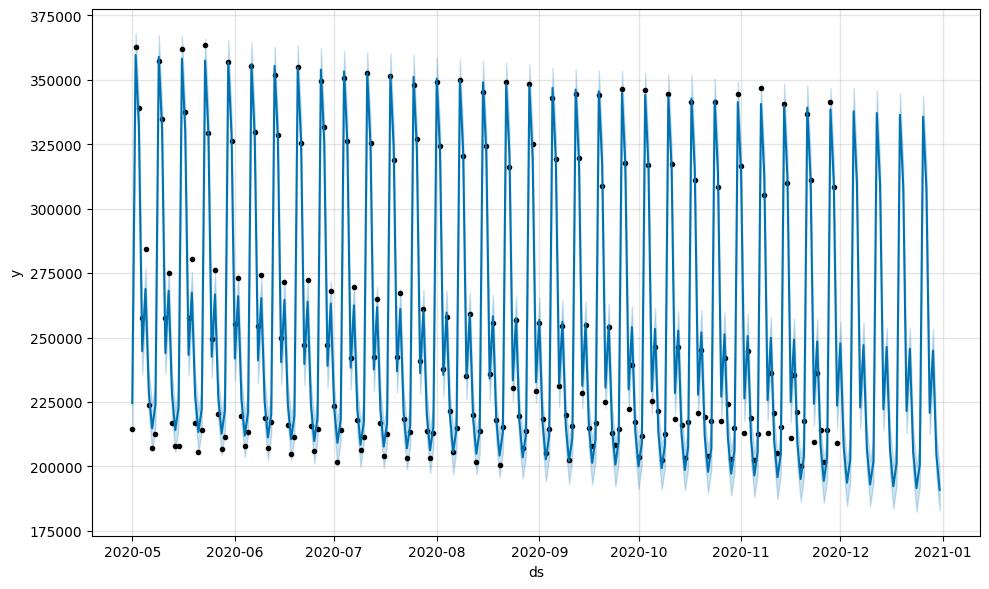

In [23]:
model.plot(forecast);

**Visualizing components**

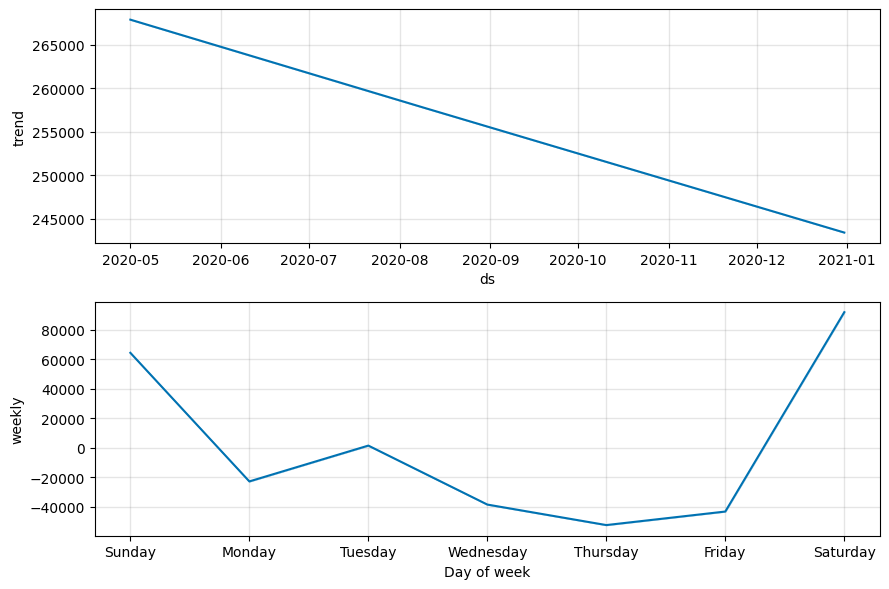

In [24]:
model.plot_components(forecast);

As we can see, there is a downtrend and clear weekly seasonality: 

- most purchases people make on Saturday and a bit less on Sunday
- on weekdays most purchases on Monday and Tuesday

### Forecast Error

Comparing the built forecast for the test period with the control data and calculating the deviation.

In [25]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test_0['y'], forecast['yhat'].tail(31))

11820.144583023754

It's not immediately clear how big the deviation that we got. Let's check the percentage.

In [26]:
np.mean(np.abs(forecast.tail(31).reset_index()['yhat'] - test_0['y']) / test_0['y']) * 100

5.412827833625983

**The mean percentage of error - 5,4. It's unacceptable and we need to improve model.**

Let's do the similar forecast for each store branch separately.

In [27]:
train.head()

,date,revenue,store_branch
0,2020-05-01,27913.47220,1
1,2020-05-01,79628.53301,2
2,2020-05-01,106898.12180,3
3,2020-05-02,37477.72056,1
4,2020-05-02,129503.46070,2


In [28]:
# Separated datasets for train

train_1 = train.loc[train['store_branch'] == 1, ['date', 'revenue']].rename({'date': 'ds', 'revenue': 'y'}, axis=1)
train_2 = train.loc[train['store_branch'] == 2, ['date', 'revenue']].rename({'date': 'ds', 'revenue': 'y'}, axis=1)
train_3 = train.loc[train['store_branch'] == 3, ['date', 'revenue']].rename({'date': 'ds', 'revenue': 'y'}, axis=1)

In [29]:
# Separated datasets for test

test_1 = test.loc[test['store_branch'] == 1, ['date', 'revenue']].rename({'date': 'ds', 'revenue':'y'}, axis=1)
test_2 = test.loc[test['store_branch'] == 2, ['date', 'revenue']].rename({'date': 'ds', 'revenue':'y'}, axis=1)
test_3 = test.loc[test['store_branch'] == 3, ['date', 'revenue']].rename({'date': 'ds', 'revenue':'y'}, axis=1)

In [30]:
# Fit new models for each store branch

model_1 = Prophet()
model_1.fit(train_1)

model_2 = Prophet()
model_2.fit(train_2)

model_3 = Prophet()
model_3.fit(train_3)

10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing


10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Forecast

forecast_1 = model_1.predict(future)

forecast_2 = model_2.predict(future)

forecast_3 = model_3.predict(future)

**Visualizing results**

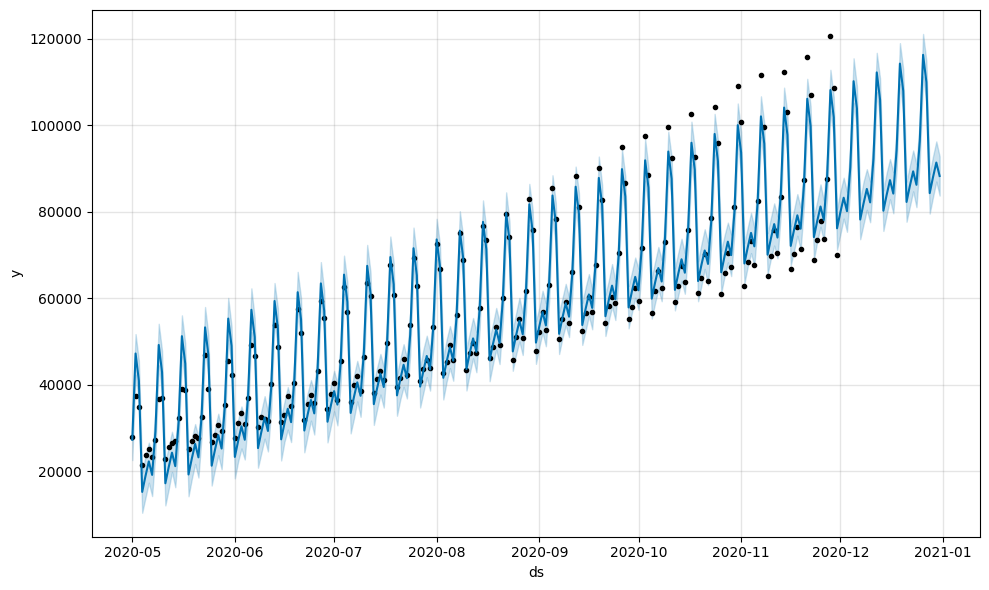

In [32]:
model_1.plot(forecast_1);

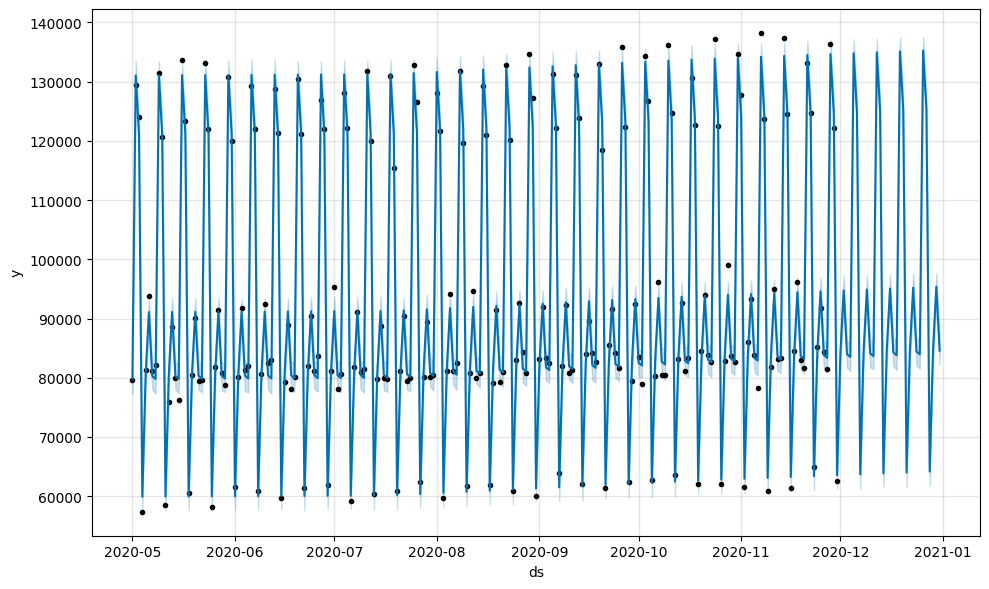

In [33]:
model_2.plot(forecast_2);

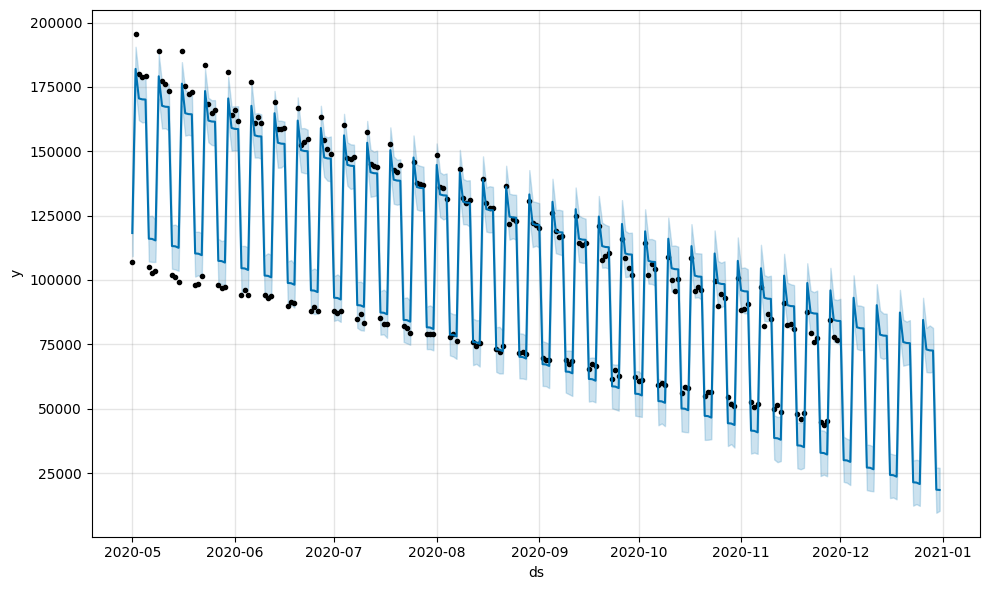

In [34]:
model_3.plot(forecast_3);

As we see on graphs, the closer to January, the more inaccurate our models. Let's try to correct them using more subtle settings.

In [35]:
# Errors of each model

forecast_1_error = mean_absolute_error(test_1['y'], forecast_1['yhat'].tail(31))
forecast_2_error = mean_absolute_error(test_2['y'], forecast_2['yhat'].tail(31))
forecast_3_error = mean_absolute_error(test_3['y'], forecast_3['yhat'].tail(31))

forecast_1_error, forecast_2_error, forecast_3_error

(5834.0547438319545, 1464.3135853912952, 13206.998318365137)

In [36]:
# Errors of each model (percentage)

abs_diff_1 = np.abs(forecast_1.tail(31).reset_index()['yhat'] - test_1.reset_index()['y'])
diff_perc_1 = np.mean(abs_diff_1/test_1.reset_index()['y']) * 100

abs_diff_2 = np.abs(forecast_2.tail(31).reset_index()['yhat'] - test_2.reset_index()['y'])
diff_perc_2 = np.mean(abs_diff_2/test_2.reset_index()['y']) * 100

abs_diff_3 = np.abs(forecast_3.tail(31).reset_index()['yhat'] - test_3.reset_index()['y'])
diff_perc_3 = np.mean(abs_diff_3/test_3.reset_index()['y']) * 100

diff_perc_1, diff_perc_2, diff_perc_3

(6.256725502273993, 1.6139820510585465, 26.754689412971246)

**The errors percentages are different for each model. Let's improve prediction for 1st and 3rd store branches and set up parameters for models.**

### Setting up the parameters

We launched the models without setting parameters. Check the main ones:

- __`groth`__ - trend

    - `liear` - when data grow or descending evenly

    - `logistic` - when the dynamics is mixed


- __`holidays`__ - data frame with holidays/weekends description to take into account while learning.


- __`seasonality`__ - seasonality

    - `yearly_seasonality` - yearly seasonality

    - `weekly_seasonality` - weekly seasonality

    - `daily_seasonality` - daily seasonality

- __`seasonality_mode`__ 

    - `additive` - means the effect of the regressor will be added to the trend. Exp: xt = Trend + Seasonal + Random
    - `multiplicative` - means it will multiply the trend. Exp: xt = Trend * Seasonal * Random


The “Random” term is often called “Irregular” in software for decomposition.

The additive model is useful when the seasonal variation is relatively constant over time. The multiplicative model is useful when the seasonal variation increases over time. 

Let's set trend and define multiplicative seasonality.

In [37]:
# Train models

model_1 = Prophet(growth='linear', weekly_seasonality=True, seasonality_mode='multiplicative')
model_1.fit(train_1)

model_2 = Prophet(growth='linear', weekly_seasonality=True, seasonality_mode='multiplicative')
model_2.fit(train_2)

model_3 = Prophet(growth='linear', weekly_seasonality=True, seasonality_mode='multiplicative')
model_3.fit(train_3)

10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing


10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
# Forecast

forecast_1 = model_1.predict(future)
forecast_2 = model_2.predict(future)
forecast_3 = model_3.predict(future)

In [39]:
# Forecast error

forecast_1_error = mean_absolute_error(test_1['y'], forecast_1['yhat'].tail(31))
forecast_2_error = mean_absolute_error(test_2['y'], forecast_2['yhat'].tail(31))
forecast_3_error = mean_absolute_error(test_3['y'], forecast_3['yhat'].tail(31))

forecast_1_error, forecast_2_error, forecast_3_error

(716.5251134167507, 1435.4336758785505, 1142.769538770527)

In [40]:
# Forecast error (percentage)

abs_diff_1 = np.abs(forecast_1.tail(31).reset_index()['yhat'] - test_1.reset_index()['y'])
diff_perc_1 = np.mean(abs_diff_1/test_1.reset_index()['y']) * 100

abs_diff_2 = np.abs(forecast_2.tail(31).reset_index()['yhat'] - test_2.reset_index()['y'])
diff_perc_2 = np.mean(abs_diff_2/test_2.reset_index()['y']) * 100

abs_diff_3 = np.abs(forecast_3.tail(31).reset_index()['yhat'] - test_3.reset_index()['y'])
diff_perc_3 = np.mean(abs_diff_3/test_3.reset_index()['y']) * 100

diff_perc_1, diff_perc_2, diff_perc_3

(0.7800874704232846, 1.5502881511541202, 2.1179617616504944)

### Errors comparison

**Error for models without parameters:** 

`Absolute:`
1. 5834.05
2. 1464.31
3. 13206.99


`Percentage: %`
1. 6.25
2. 1.61
3. 26.75


**Error for models with parameters (growth, seasonality, seasonality mode):**

`Absolute:`
1. 716.52
2. 1435.43
3. 1142.76


`Percentage: %`
1. 0.78
2. 1.55
3. 2.11


**Now our forecast is more accurate. As in main task we need to make a forecast for total revenue from all 3 store branches, we can sum predicted revenues from all 3 results and check the error.**

In [41]:
# Forecasts sum

f1 = forecast_1.tail(31).reset_index()['yhat']
f2 = forecast_2.tail(31).reset_index()['yhat']
f3 = forecast_3.tail(31).reset_index()['yhat']

total_forecast = f1 + f2 + f3

mean_absolute_error(test_0['y'], total_forecast)

1934.250485613839

Now as the model is selected, we need to rebuild the model over the entire dataset and make a forecast for January.

In [42]:
# Preparing data from the May till December
data_revenue_1 = revenue_data.loc[revenue_data['store_branch'] == 1].drop('store_branch', axis=1).rename({'date': 'ds', 'revenue': 'y'}, axis=1)
data_revenue_2 = revenue_data.loc[revenue_data['store_branch'] == 2].drop('store_branch', axis=1).rename({'date': 'ds', 'revenue': 'y'}, axis=1)
data_revenue_3 = revenue_data.loc[revenue_data['store_branch'] == 3, ['date', 'revenue']].rename({'date': 'ds', 'revenue': 'y'}, axis=1)


# Training the model
model_1 = Prophet(growth='linear', weekly_seasonality=True, seasonality_mode='multiplicative')
model_1.fit(data_revenue_1)

model_2 = Prophet(growth='linear', weekly_seasonality=True, seasonality_mode='multiplicative')
model_2.fit(data_revenue_2)

model_3 = Prophet(growth='linear', weekly_seasonality=True, seasonality_mode='multiplicative')
model_3.fit(data_revenue_3)


# Creating future data frame for January
future = model_1.make_future_dataframe(periods=31)


# Forecast for January
forecast_1 = model_1.predict(future)
forecast_2 = model_2.predict(future)
forecast_3 = model_3.predict(future)


10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing


10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Sum predicted revenues

f1 = forecast_1.tail(31)[['ds', 'yhat']].set_index('ds')
f2 = forecast_2.tail(31)[['ds', 'yhat']].set_index('ds')
f3 = forecast_3.tail(31)[['ds', 'yhat']].set_index('ds')

total_forecast = (f1 + f2 + f3)

In [44]:
total_forecast.head()

,yhat
ds,
2021-01-01,217039.946959
2021-01-02,332637.022727
2021-01-03,305663.245842
2021-01-04,198809.117155
2021-01-05,224969.837166


**Now we got the forecast for total revenue of all store branches. As we know that the model has the error about 1-2%, with high probability we can be confident that the model made accurate forecast.**

In [45]:
total_forecast.reset_index(inplace=True)
total_forecast[['ds', 'yhat']]
total_forecast.rename(columns = {'ds': 'date', 'y': 'revenue'}).head()

,date,yhat
0,2021-01-01,217039.946959
1,2021-01-02,332637.022727
2,2021-01-03,305663.245842
3,2021-01-04,198809.117155
4,2021-01-05,224969.837166


In [46]:
total_forecast.to_csv('forecast_jan.csv')